<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/DL_week_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.В прошлом вебинаре

### 1.Слои нормализации

Какие проблемы возникают  при обучении нейронных сетей:


**1. Устранение дисбаланса масштабов признаков**
Проблема: Если признаки имеют разные диапазоны (например, возраст: 0–100, доход: 0–1 000 000), градиенты по параметрам сети будут неравномерными. Признаки с большими значениями могут доминировать, искажая процесс обучения.


**2. Ускорение сходимости обучения**
Градиентные методы (SGD, Adam) быстрее находят оптимум, когда поверхность функции потерь более "сглажена". Без нормализации оптимизатор совершает хаотичные шаги по одним измерениям и слишком мелкие — по другим.

Пример: Данные в диапазоне [−1, 1] позволяют использовать большие скорости обучения без риска расходимости.

**3. Борьба с внутренним ковариационным сдвигом (Internal Covariate Shift)**
Суть: Распределение входов слоёв меняется во время обучения из-за обновления параметров предыдущих слоёв. Это дестабилизирует обучение.

**4. Предотвращение насыщения активационных функций**
Функции вроде сигмоиды или гиперболического тангенса «насыщаются» при больших входных значениях, что приводит к исчезающим градиентам.

Решение: Batch Normalization (BN) нормализует активации каждого слоя по мини-батчам, стабилизируя среднее и дисперсию. Это позволяет использовать более высокие learning rates и упрощает инициализацию весов.


[Статья](https://arxiv.org/pdf/1502.03167) от Google 2015 года, где была описана ```batch normalization```.

#### 1.1**Как работает Batch Normalization?**

1. **Вычисление статистики для мини-батча**  
   Для каждого признака (канала/нейрона) в активациях слоя вычисляются:  
   - **Среднее значение** по мини-батчу:  
     $$\mu = \frac{1}{m} \sum_{i=1}^m x_i$$  
   - **Дисперсия** по мини-батчу:  
     $$\sigma^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu)^2$$  
     где \(m\) — размер мини-батча, \(x_i\) — активации из батча.

2. **Нормализация**  
   Каждое значение в батче преобразуется к нулевому среднему и единичной дисперсии:  
   $$\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$$  
   Здесь:  
   - $\epsilon$ — малое число (например, \(10^{-5}\)), чтобы избежать деления на ноль.  
   - Корень из дисперсии $\sqrt{\sigma^2 + \epsilon}$ называется **стандартным отклонением**.

3. **Масштабирование и сдвиг**  
   Вводятся два **обучаемых параметра**:  
   - $\gamma$ (масштаб) — регулирует "ширину" распределения.  
   - $\beta$ (сдвиг) — регулирует смещение распределения.  
   Итоговый выход слоя:  
   $$y_i = \gamma \cdot \hat{x}_i + \beta$$  
   Это позволяет сети:  
   - Сохранить выразительность (если нормализация не нужна, $\gamma = \sqrt{\sigma^2}$, $\beta = \mu$).  
   - Адаптировать распределение под задачу.

---

#### **Пример вычислений**  
Допустим, мини-батч состоит из 4 примеров, и для нейрона получены активации:  
`[2.0]`  
1. $\mu = \frac{2}{1} = 2.0$  
2. $\sigma^2 = \frac{(2-2)^2}{1} = 0.0$
3. $\hat{x}_i = \frac{x_i - 2}{\sqrt{0 + 1e-5}} \approx \frac{2 - 2}{0}$  
   После нормализации: `[-1.342, -0.447, 0.447, 1.342]`  
4. Если $\gamma = 1.5\), \(\beta = 0.1\$, итоговые значения:  
   `[-1.342*1.5 + 0.1, ..., 1.342*1.5 + 0.1] ≈ [-1.913, -0.570, 0.770, 2.113]`.

#### <font color='DarkOrange'>**Вопрос (?)**</font> Что такое батч?

##### **Что такое батч (batch)?**  
**Батч** (или **мини-батч**) — это подмножество данных из общего набора, которое обрабатывается нейронной сетью **за один шаг обучения**. Например, если в датасете 10 000 изображений, а размер батча — 100, то за одну эпоху сеть обработает все данные за 100 шагов (10 000 / 100 = 100 итераций).

---

#### **Зачем нужны батчи?**
1. **Эффективность памяти**  
   Обработка всего датасета за раз (batch size = весь датасет) требует огромных вычислительных ресурсов. Мини-батчи позволяют обучать модель даже на слабом железе.

2. **Скорость обучения**  
   Обновление весов после каждого батча (а не после всей эпохи) ускоряет сходимость.  
   *Пример:* Стохастический градиентный спуск (SGD) использует батчи для приближённого расчёта градиента.

3. **Регуляризация**  
   Шум, возникающий из-за случайности выбора батчей, помогает избежать переобучения.

4. **Совместимость с методами вроде Batch Normalization**  
   Нормализация активаций требует статистики по батчу (среднее, дисперсия).

---

#### **Типы обучения по батчам**
- **Полный батч (Batch Gradient Descent):**  
  Размер батча = весь датасет.  
  Плюсы: точные градиенты.  
  Минусы: медленно, требует много памяти.

- **Стохастический (Stochastic Gradient Descent):**  
  Размер батча = 1 (каждый пример обрабатывается отдельно).  
  Плюсы: быстрая сходимость, подходит для онлайн-обучения.  
  Минусы: шумные обновления градиентов.

- **Мини-батч (Mini-batch Gradient Descent):**  
  Размер батча = N (обычно 32, 64, 128 и т.д.).  
  Золотая середина: баланс между стабильностью и скоростью.

---

#### **Как выбрать размер батча?**
- **Малый размер (32–128):**  
  Подходит для большинства задач, особенно при ограниченной памяти GPU.  
  Лучше для регуляризации, но требует больше итераций.

- **Большой размер (256–1024):**  
  Ускоряет обработку (оптимизация через матричные операции), но может ухудшить обобщение.  

- **Эмпирическое правило:**  
  Выбирайте максимальный размер, который "влезает" в память, не жертвуя качеством.

---

#### **Пример**  
- Датасет: 5000 изображений кошек и собак.  
- Batch size: 64.  
- Шагов за эпоху: 5000 / 64 ≈ 78 итераций.  
- На каждой итерации: сеть получает 64 изображения, вычисляет потерю, обновляет веса.


#### 1.2 Как батч-нормализация влияет на обучение нейронных сетей?

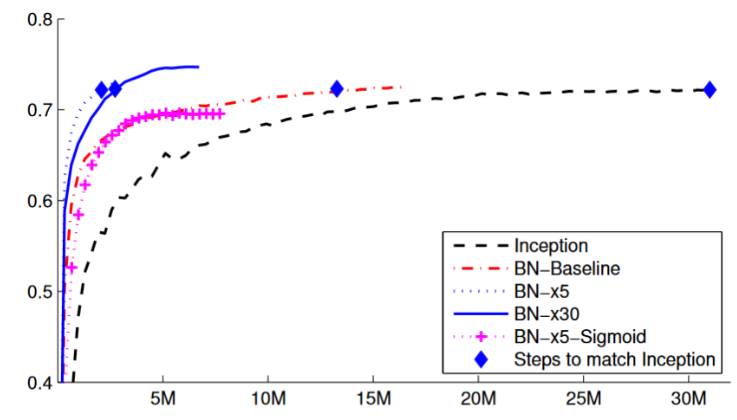

#### 1.3 Как батч-нормализация работает при обучении и на тестировании

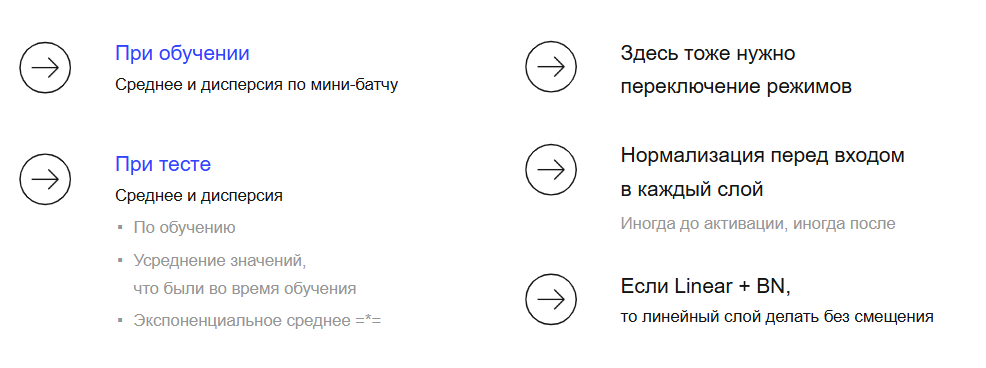

In [ ]:
import torch
from torch import nn

In [ ]:
bn1 = nn.BatchNorm1d (num_features=128,
                      eps=1e-05,
                      momentum=0.1,            # Определяет, как обновляются скользящие средние
                      affine=True,             # Включает обучаемые параметры масштаба \gamma и \beta
                      track_running_stats=True # Включает расчет скользящих средних
                      )

#### 1.4 Другие варианты нормализации

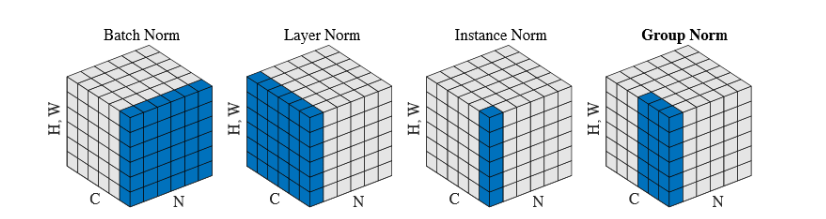

- Layer Normalization – Ba, Kiros, and Hinton, «Layer Normalization», arXiv 2016
- Instance Normalization – Ulyanov et al «Improved Texture Networks: Maximizing Quality and Diversity in Feed-forward Stylization and Texture Synthesis», CVPR 2017
- Group Normalization – Wu and He, «Group Normalization» arXiv 2018

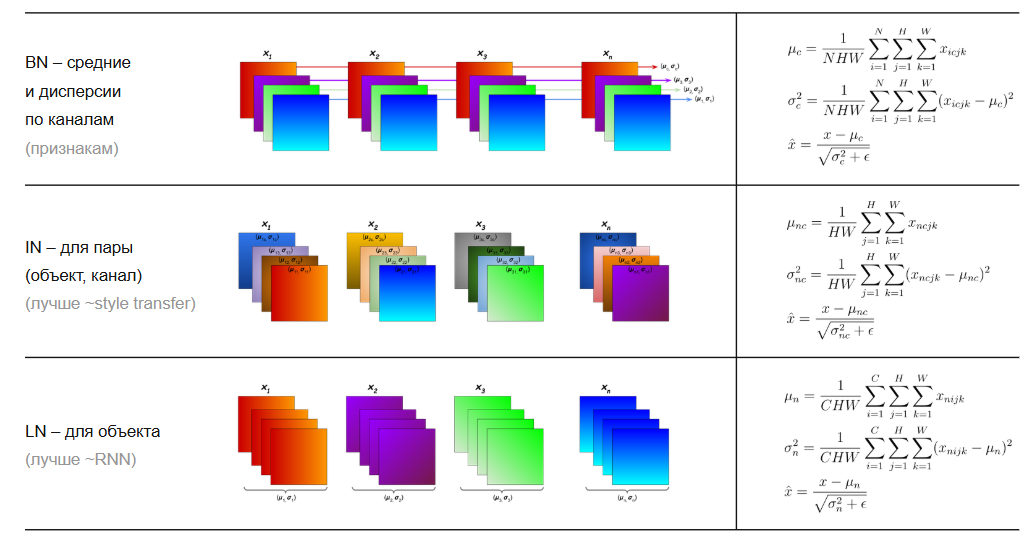

#### <font color='DarkOrange'>**Вопрос (?)**</font> Почему Layer Norm больше подходит для нейросетей для текстовых данных (RNN)?

#### 1.5 Кастомная реализация batch-norm

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        # prediction mode - directly use the mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # fully-connected layer => calculate the mean and variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # two-dimensional convolutional layer => mean and variance on axis=1 (channel)
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

class BatchNorm(nn.Module):
    # `num_features`: # outputs for a fully-connected layer or # output channels for a convolutional layer.
    # `num_dims`: 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # copy `moving_mean` and `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean,
                                                          self.moving_var, eps=1e-5, momentum=0.9)
        return Y

### 2.Слой dropout

##### **Слой Dropout**  
**Dropout** — это метод регуляризации, используемый в нейронных сетях для предотвращения переобучения. Он работает путем случайного "отключения" (обнуления) части нейронов во время обучения, заставляя сеть учиться более устойчивым и обобщающим признакам.

---

### **Как работает Dropout?**  
1. **На этапе обучения:**  
   - Для каждого нейрона в слое с вероятностью `p` (гиперпараметр) его выходное значение обнуляется.  
   - Например, если `p = 0.5`, каждый нейрон имеет 50% шанс быть временно удалённым на текущем шаге обучения.  
   - Оставшиеся активные нейроны масштабируются на коэффициент `1 / (1 - p)`, чтобы сохранить мат. ожидание суммы входов следующего слоя.

2. **На этапе тестирования/инференса:**  
   - Все нейроны остаются активными.  
   - Веса сети масштабируются на `(1 - p)`, чтобы компенсировать отсутствие dropout.  
   *Пример:* Если `p = 0.2`, выходы слоя умножаются на `0.8`.

---

### **Зачем нужен Dropout?**  
1. **Борьба с переобучением (overfitting):**  
   - Случайное отключение нейронов предотвращает чрезмерную адаптацию сети к шумам в тренировочных данных.  
   - Сеть вынуждена распределять "знания" между всеми нейронами, а не запоминать данные через отдельные узлы.

2. **Эффект ансамбля моделей:**  
   На каждом шаге обучения активируется случайное подмножество нейронов, что эквивалентно обучению множества "подсетей" (ансамбля), которые затем усредняются.

3. **Уменьшение коадаптации нейронов:**  
   Нейроны учатся работать независимо, а не полагаться на конкретные связи.

---

### **Гиперпараметр `p`**  
- **`p`** — вероятность отключения нейрона (обычно `0.2 ≤ p ≤ 0.5`).  
  - Для входных слоев: `p = 0.1–0.2`.  
  - Для скрытых слоев: `p = 0.5`.  
- Слишком большое `p` может привести к недообучению, слишком маленькое — к слабой регуляризации.

---

### **Пример реализации в PyTorch**  
```python
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Отключает 50% нейронов
    nn.Linear(256, 10)
)
```

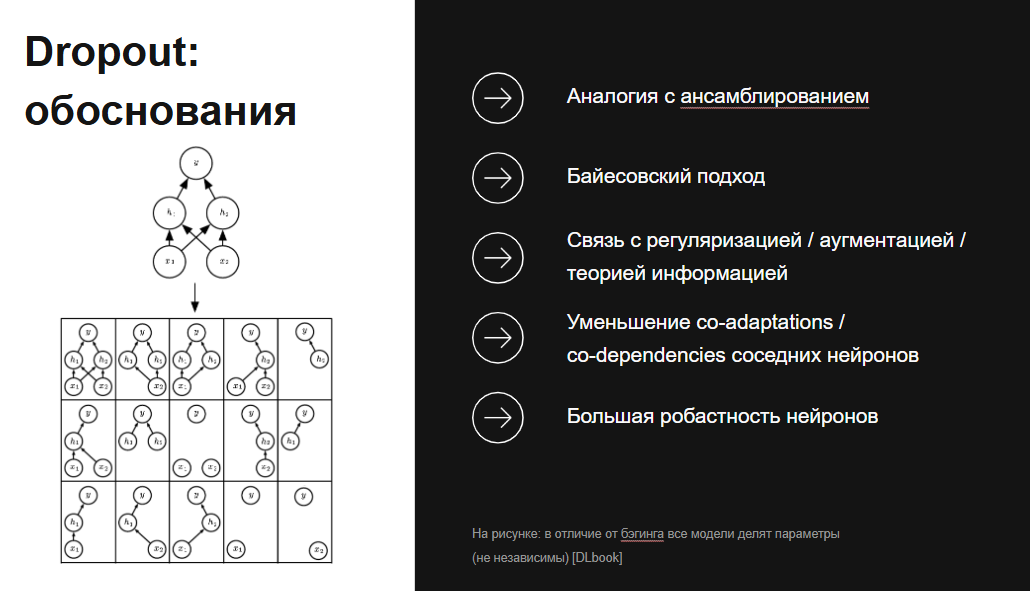

In [ ]:
import torch.nn as nn

# Создание слоя Dropout с вероятностью отключения нейронов 30%
dropout_layer = nn.Dropout(p=0.3,        # Вероятность отключения (обнуления) каждого нейрона в слое на текущем шаге обучения.
                           inplace=False # Модифицирует входной тензор напрямую (экономит память)
                           )

#### <font color='DarkOrange'>**Вопрос (?)**</font> На что из линейных моделей похож `dropout`?

### 3.Инициализация весов
Правильную инициализацию весов pytorch делает **за нас!**

Этот раздел нужен для понимая основных правил инициализации весов нейронных сетей.

#### 3.1 Основные идеи при инициализации весов нейронных сетей

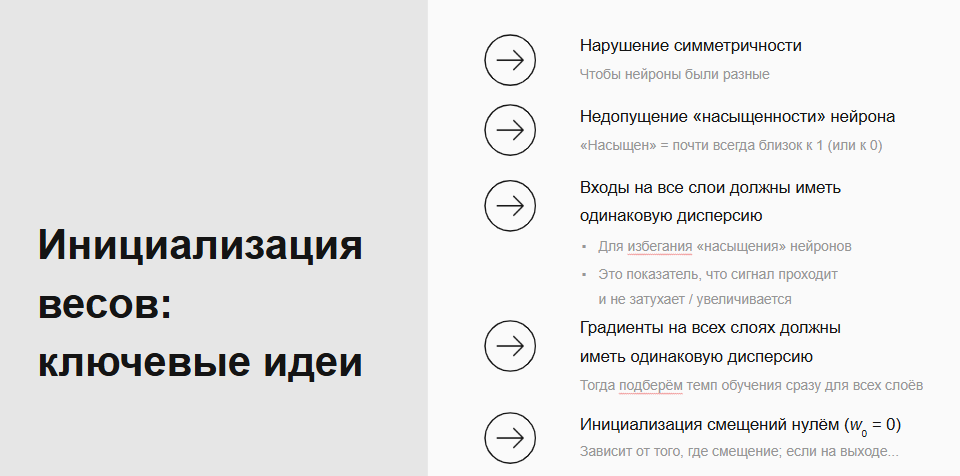

#### 3.2 Как это выглядит в коде

In [ ]:
from torch.nn import init

In [ ]:
m = nn.Linear(20, 30)
# 1. Kaiming (He) инициализация:
init.kaiming_normal_(m.weight, mode='fan_in',
                     nonlinearity='relu')

# 2. Xavier (Glorot) инициализация:
init.xavier_normal_(m.weight,
                    gain=nn.init.calculate_gain('tanh'))

# 3. Нулевая инициализация смещений:
init.constant_(m.bias, 0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.], requires_grad=True)

**Важные нюансы**
1. Всегда инициализируйте веса и смещения отдельно

2. Для BatchNorm:

- Веса (γ) инициализируйте в 1

- Смещения (β) в 0

Для выходного слоя иногда используют:
```python
init.normal_(m.weight, mean=0, std=0.01)
init.constant_(m.bias, 0)

```

### 4.Собираем итоговую многослойную сеть

#### 4.1 Было

In [ ]:
import torch
from torchsummary import summary

In [ ]:
# определяем девайс на котором будем создавать нашу нейронную сеть
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
class Feedforward(torch.nn.Module):
    """
    Простая полносвязная нейронная сеть (feedforward).

    Args:
        input_size (int): Размерность входного вектора.
        hidden_size (int): Размерность скрытого слоя.
    """
    def __init__(self, input_size, hidden_size):
        super(Feedforward, self).__init__()

        # Запоминаем размеры входного и скрытого слоев
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Первый полносвязный (линейный) слой
        # input_size -> hidden_size  без bias
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size,
                                   bias=True)

        # Функция активации ReLU
        self.relu = torch.nn.ReLU()

        # Второй полносвязный (линейный) слой
        # hidden_size -> 1  без bias
        self.fc2 = torch.nn.Linear(self.hidden_size, 1,
                                   bias=True)

        # Функция активации Sigmoid (для выходного слоя, подходит для бинарной классификации)
        self.sigmoid = torch.nn.Sigmoid()


    def forward(self, x):
        """
        Прямой проход данных через сеть.

        Args:
            x (torch.Tensor): Входной тензор.

        Returns:
            torch.Tensor: Выходной тензор.
        """
        # Вычисляем выход первого слоя
        hidden = self.fc1(x)

        # Применяем ReLU к выходу первого слоя
        relu = self.relu(hidden)

        # Вычисляем выход второго слоя
        output = self.fc2(relu)

        # Применяем Sigmoid к выходу второго слоя
        output = self.sigmoid(output)

        return output

In [ ]:
net = Feedforward(2, 3).to(device=device)
x = torch.tensor([1., 2.]).to(device=device)
net(x)

tensor([0.4482], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
summary(net, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
              ReLU-2                    [-1, 3]               0
            Linear-3                    [-1, 1]               4
           Sigmoid-4                    [-1, 1]               0
Total params: 13
Trainable params: 13
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


#### 4.2 Стало

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init

class AdvancedFeedforward(nn.Module):
    """
    Улучшенная полносвязная нейронная сеть с:
    - Инициализацией весов
    - Батч-нормализацией
    - Dropout

    Args:
        input_size (int): Размерность входного вектора
        hidden_size (int): Размерность скрытого слоя
        dropout_prob (float): Вероятность дропаута (по умолчанию 0.5)
    """
    def __init__(self, input_size, hidden_size, dropout_prob=0.5):
        super(AdvancedFeedforward, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # Первый полносвязный слой
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Батч-нормализация после первого слоя
        self.bn1 = nn.BatchNorm1d(hidden_size,
                                  affine=True,
                                  track_running_stats=True)

        # ReLU активация
        self.relu = nn.ReLU()

        # Dropout слой
        self.dropout = nn.Dropout(p=dropout_prob)

        # Второй полносвязный слой
        self.fc2 = nn.Linear(hidden_size, 1)

        # Сигмоида для выходного слоя
        self.sigmoid = nn.Sigmoid()

        # Инициализация весов
        self._initialize_weights()

    def _initialize_weights(self):
        """Кастомная инициализация весов"""
        # Инициализация Kaiming для линейных слоев
        init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')

        # Инициализация смещений нулями
        init.constant_(self.fc1.bias, 0)
        init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        # Первый слой -> батч-норма -> активация -> дропаут
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Второй слой -> сигмоида
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [ ]:
net = AdvancedFeedforward(2, 3, 0.3).to(device=device)
x = torch.tensor([
                [1., 2.],
                [2., 3.]
                ]).to(device=device)
net(x)

tensor([[0.3445],
        [0.3371]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
summary(net, (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               9
       BatchNorm1d-2                    [-1, 3]               6
              ReLU-3                    [-1, 3]               0
           Dropout-4                    [-1, 3]               0
            Linear-5                    [-1, 1]               4
           Sigmoid-6                    [-1, 1]               0
Total params: 19
Trainable params: 19
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


##### <font color='DarkOrange'>**Вопрос (?)**</font> Почему у batch norm 6 параметров?

## Вебинар 4:  Функции потерь и математический фундамент обучения нейронных сетей

Погрузимся в математический фундамент обучения нейросетей, разберем функции потерь.

На следующем вебинаре разберем метод обратного распространения ошибки.



### 1.Как обучаются нейронные сети?

#### 1.0 Что такое производная функции в точке?

**Производная функции** — это математическая мера, показывающая скорость изменения функции при изменении её аргумента. Она отвечает на вопрос:  
*«Если слегка изменить вход функции \( x \), насколько сильно изменится её выход \( f(x) \)?»*

---
### 1. Скорость изменения
Производная $ f'(x)$ описывает мгновенную скорость изменения функции.  
**Пример**:  
Если $ f(t) $ — путь объекта в зависимости от времени, то $ f'(x)$ — его **скорость**.

### 2. Геометрический смысл
Производная равна **угловому коэффициенту касательной** к графику функции в точке $x$.  
Чем круче график, тем больше значение производной.

![Геометрический смысл производной](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Tangent_to_a_curve.svg/800px-Tangent_to_a_curve.svg.png)

### 3. Формальное определение
Производная функции $f(x)$ в точке $x$ — это предел:  
$$
f'(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}.
$$

---

## Пример вычисления
**Функция**: $f(x) = x^2$.  
**Найдём производную**:  
$$
f'(x) = \lim_{h \to 0} \frac{(x + h)^2 - x^2}{h} = \lim_{h \to 0} \frac{x^2 + 2xh + h^2 - x^2}{h} = \lim_{h \to 0} (2x + h) = 2x.
$$
**Итог**: $f'(x) = 2x$. Это означает, что скорость изменения $ x^2 $ в любой точке $x$ равна $2x$.


## Правила дифференцирования
1. **Константа**:  
   $f(x) = c \quad \Rightarrow \quad f'(x) = 0 $

2. **Степенная функция**:  
   $f(x) = x^n \quad \Rightarrow \quad f'(x) = n \cdot x^{n-1}$  
   Пример: $(x^3)' = 3x^2$.

3. **Сумма функций**:  
   $(f(x) + g(x))' = f'(x) + g'(x)$

4. **Произведение функций**:  
   $(f(x) \cdot g(x))' = f'(x) \cdot g(x) + f(x) \cdot g'(x)$

---

## Важные замечания
- Производная — это **локальное свойство** (зависит от точки \( x \)).
- Если \( f'(x) > 0 \), функция **растёт**; если \( f'(x) < 0 \), функция **убывает**.
- Чем больше модуль производной (\( |f'(x)| \)), тем «круче» график.

## Самое важное замечание
- Если \( f'(x) = 0 \), функция имеет **экстремум** (либо максимум, либо минимум)

**Производные** — основа алгоритмов машинного обучения, таких как градиентный спуск, без которого невозможно обучение нейросетей 🚀.

##### <font color='DarkOrange'>**Вопрос (?)**</font> Чему равна производная функции $f(x) = x^3 - 2\cdot x^2 -3$

### 1.1Что такое градиент функции?

**Градиент функции** — это вектор, который показывает направление **наискорейшего роста** функции в данной точке. Он состоит из частных производных функции по всем её переменным. Градиент обозначается символом ∇ (набла) и широко используется в оптимизации, физике и машинном обучении.

---

## Основные свойства

### 1. Определение
Для функции $f(x_1, x_2, ..., x_n)$ градиент вычисляется как:  
$$
\nabla f = \left( \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, ..., \frac{\partial f}{\partial x_n} \right),
$$
где $ \frac{\partial f}{\partial x_i}$ — частная производная по переменной $ x_i $.

### 2. Геометрический смысл
- Градиент указывает направление, в котором функция растёт быстрее всего.
- Длина вектора градиента (норма) показывает скорость этого роста.
- В точке **локального минимума** или **максимума** градиент равен нулю $\nabla f = 0$.

![Градиент](https://i.pinimg.com/736x/d6/7f/5e/d67f5eaff9b6e102c4cd7ef57c1190a2.jpg)

---

## Пример вычисления
**Функция**: $ f(x, y) = x^2 + y^2 $.  
**Найдём градиент**:  
$$
\nabla f = \left( \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right) = (2x; 2y).
$$  
**Интерпретация**:  
В точке (1; 1) градиент равен (2; 2). Это означает, что функция растёт быстрее всего в направлении вектора (2; 2).




## Важные замечания
1. **Градиент vs производная**:  
   - Для функции одной переменной градиент совпадает с производной.  
   - Для многомерных функций градиент — это вектор из частных производных.

2. **Визуализация**:  
   Градиент перпендикулярен **линиям уровня** функции (см. рисунок выше).

3. **Ограничения**:  
   Градиентный спуск может застревать в локальных минимумах, если функция не выпуклая.

---

**Градиент** — ключевой инструмент в оптимизации и машинном обучении. Без него невозможно обучение нейросетей, подбор параметров моделей и решение многих научных задач 🚀.

##### <font color='DarkOrange'>**Вопрос (?)**</font> Какая размерность будет у градиента для функции $f(x, y, z) = x^3 - 2\cdot y^2 -3 \cdot z$

### 1.2Метод стохастического градиентного спуска

# Метод стохастического градиентного спуска (SGD)

**Стохастический градиентный спуск (SGD)** — это алгоритм оптимизации, используемый для минимизации функции потерь в машинном обучении. В отличие от классического градиентного спуска, который использует **весь набор данных** для вычисления градиента, SGD обновляет параметры модели на основе **случайно выбранного примера** (или небольшой группы примеров — мини-батча). Это делает его быстрым и подходящим для больших данных.

---

## Основная идея
1. **Случайный выбор**: На каждом шаге SGD берёт **один случайный пример** (или мини-батч) из обучающей выборки.
2. **Локальный градиент**: Вычисляет градиент функции потерь только для этого примера.
3. **Обновление параметров**: Корректирует веса модели в направлении, противоположном градиенту, чтобы уменьшить ошибку.

Формула обновления весов:  
$$
w_{\text{новый}} = w_{\text{старый}} - \eta \cdot \nabla L_i(w),
$$  
где:
- $ \eta $ — скорость обучения (learning rate),
- $ \nabla L_i(w) $ — градиент функции потерь для \( i\)-го примера.

---

## Преимущества SGD
- **Скорость**: Не требует вычисления градиента по всем данным, что критично для больших датасетов.
- **Память**: Экономит память, так как обрабатывает данные небольшими порциями.
- **Побег из локальных минимумов**: Шум, вызванный случайными примерами, помогает избежать застревания в плохих оптимумах.
- **Обобщение**: Частые обновления весов могут улучшить способность модели к обобщению.

---

## Недостатки
- **Высокая дисперсия**: Шаги обновления сильно зависят от случайных примеров, что приводит к "дрожанию" процесса обучения.
- **Настройка скорости обучения**: Требует аккуратного выбора $ \eta $. Слишком большой шаг → расходимость, слишком маленький → медленная сходимость.
- **Сходимость**: Может потребовать больше эпох для достижения минимума по сравнению с batch GD.

---

## Пример работы
**Дано**:  
- Функция потерь: $ L(w) = (w - 5)^2 $.  
- Начальный вес: $ w = 0 $, скорость обучения $ \eta = 0.1 $.  

**Шаги**:
1. Случайно выбираем пример (в данном случае функция одна, так как задача упрощена).
2. Вычисляем градиент: $ \nabla L(w) = 2(w - 5) $.
3. Обновляем вес:  
   $$
   w_{\text{новый}} = 0 - 0.1 \cdot 2(0 - 5) = 0 + 1 = 1.
   $$
4. Повторяем шаги, пока $ w $ не приблизится к 5 (оптимальное значение).

---

## SGD vs Mini-Batch GD
- **SGD**: Использует **1 пример** за шаг. Максимально стохастичен, но шаги очень шумные.  
- **Mini-Batch GD**: Использует **небольшую группу примеров** (например, 32 или 128). Баланс между скоростью и стабильностью.  
- **Batch GD**: Использует **все данные**. Точно вычисляет градиент, но медленно работает на больших данных.

---


### 2.Функции потерь в нейронных сетях

# Функции потерь в нейронных сетях

**Функция потерь (Loss Function)** — это метрика, которая измеряет, насколько предсказания нейронной сети отличаются от истинных значений. Цель обучения — минимизировать значение этой функции, подстраивая веса модели. Функция потерь определяет, "что именно" и "как" должна оптимизировать сеть.

---

## Основные функции потерь

### 1. **MSE (Mean Squared Error)**  
**Формула**:  
$$
L = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$
**Применение**: Регрессия (предсказание чисел).  
**Преимущества**:  
- Простая в вычислении и дифференцировании.  
- Сильно штрафует большие ошибки.  
**Недостатки**:  
- Чувствительна к выбросам (из-за квадратичной зависимости).  
- Может медленно сходиться для задач классификации.

---

### 2. **Бинарная кросс-энтропия (Binary Cross-Entropy)**  
**Формула**:  
$$
L = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$
**Применение**: Бинарная классификация (два класса).  
**Преимущества**:  
- Оптимальна для вероятностных выходов (например, с сигмоидой).  
- Устойчива к дисбалансу классов при использовании весов.  
**Недостатки**:  
- Не подходит для многоклассовой классификации.  
- Может страдать от проблем с численной стабильностью (логарифм нуля).

---

### 3. **Категориальная кросс-энтропия (Categorical Cross-Entropy)**  
**Формула**:  
$$
L = -\frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C y_{i,c} \log(\hat{y}_{i,c})
$$  
**Применение**: Многоклассовая классификация (\( C \) классов).  
**Преимущества**:  
- Эффективна для задач с несколькими классами.  
- Работает с вероятностями (выход softmax).  

**Недостатки**:  
- Требует one-hot кодирования целевых переменных.  
- Чувствительна к переобучению при малом количестве данных.

---

### 4. **Hinge Loss**  
**Формула**:  
$$
L = \frac{1}{N} \sum_{i=1}^N \max(0, 1 - y_i \cdot \hat{y}_i)
$$  
**Применение**: SVM-подобные модели, бинарная классификация.  
**Преимущества**:  
- Устойчива к шуму в данных.  
- Создает большой зазор (margin) между классами.  
**Недостатки**:  
- Не дает вероятностный вывод.  
- Менее популярна в глубоком обучении (чаще используется в линейных моделях).

---

### 5. **Huber Loss**  
**Формула**:  
$$
L = \begin{cases}
\frac{1}{2} (y - \hat{y})^2, & \text{если } |y - \hat{y}| \leq \delta, \\
\delta \cdot (|y - \hat{y}| - \frac{\delta}{2}), & \text{иначе}.
\end{cases}
$$
**Применение**: Регрессия, устойчивая к выбросам.  
**Преимущества**:  
- Менее чувствительна к выбросам, чем MSE.  
- Сочетает свойства MSE и MAE.  
**Недостатки**:  
- Требует подбора гиперпараметра $ \delta $.


---

## Как выбрать функцию потерь?
1. **Регрессия**: MSE, MAE, Huber Loss.  
2. **Бинарная классификация**: Бинарная кросс-энтропия, Hinge Loss.  
3. **Многоклассовая классификация**: Категориальная кросс-энтропия.  
---

## Ключевые принципы
- **Совместимость с активационными функциями**: Например, кросс-энтропия работает с softmax/sigmoid, а MSE — с линейной активацией.  
- **Учет выбросов**: Если данные зашумлены, используйте Huber Loss вместо MSE.  
- **Интерпретируемость**: MSE интуитивна, но кросс-энтропия лучше отражает "уверенность" модели в классификации.  

**Функция потерь** — это "компас" обучения нейросети. Правильный выбор ускоряет сходимость и улучшает качество модели.

### 3.Пример обучения однослойной нейронной сети

In [21]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.6.0+cu124'

#### 3.1 Подготовка данных

In [22]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [23]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [24]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

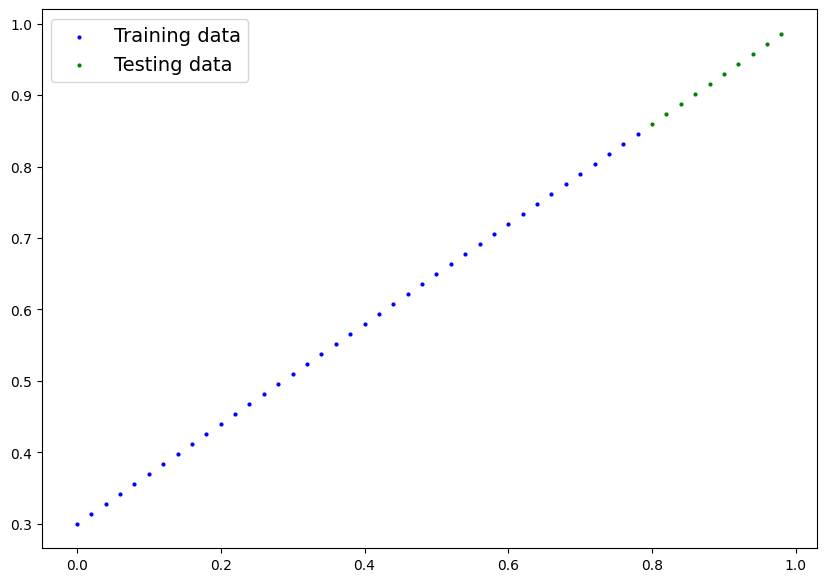

In [25]:
plot_predictions();

#### 3.2 Создадим однослойную нейронную сеть

In [26]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [27]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

#### 3.3 Использование нашей нейронной сети для задачи регрессии

In [28]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

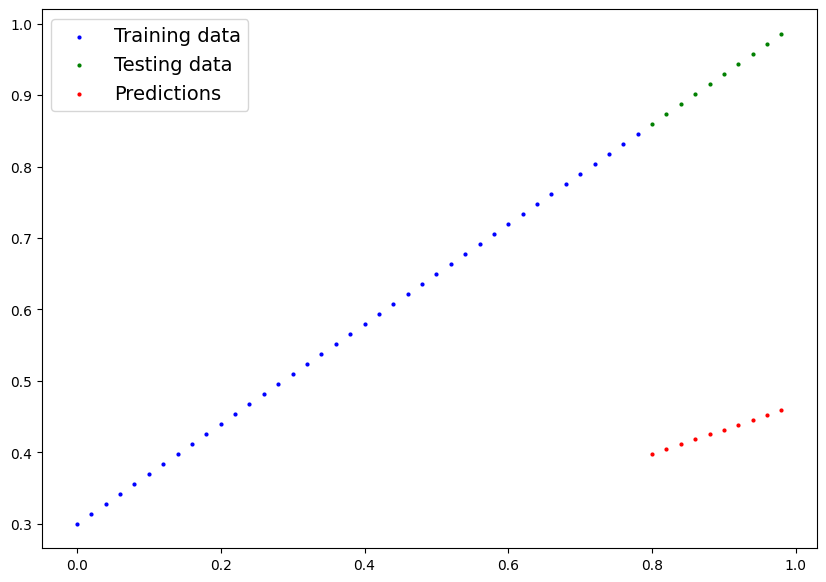

In [29]:
plot_predictions(predictions=y_preds)

##### <font color='DarkOrange'>**Вопрос (?)**</font> Почему наша нейронная сеть там промахивается с ответом?

#### 3.4 Давайте научим нашу модель правильно решать задачу

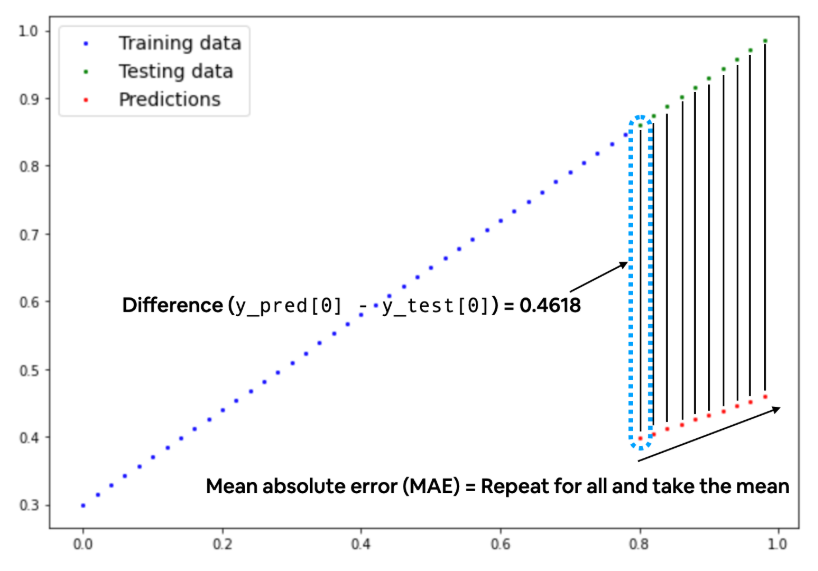

##### <font color='DarkOrange'>**Вопрос (?)**</font> Что будет функцией потерь для нашей задачи

In [30]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

In [31]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01)
# learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


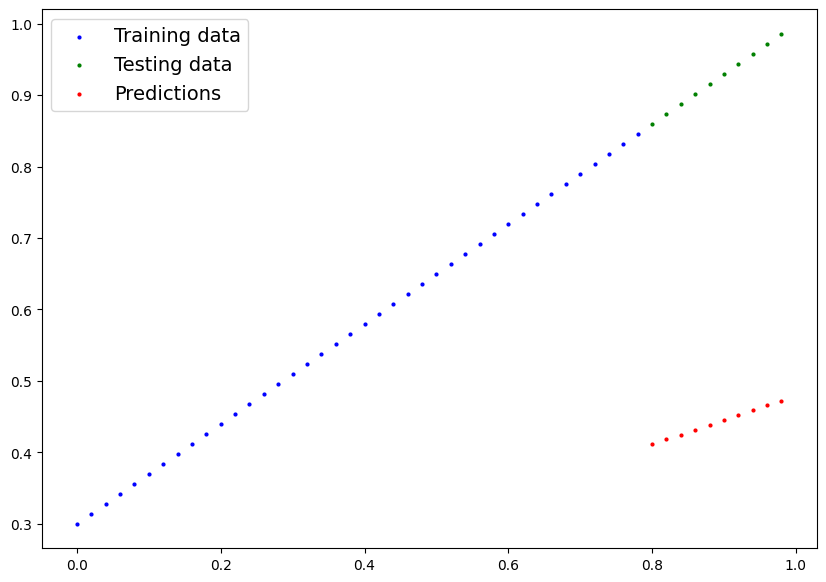

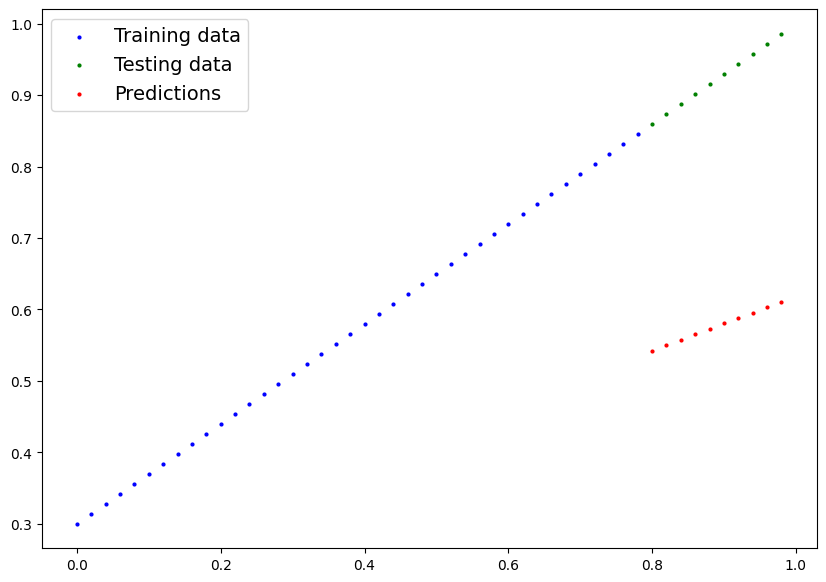

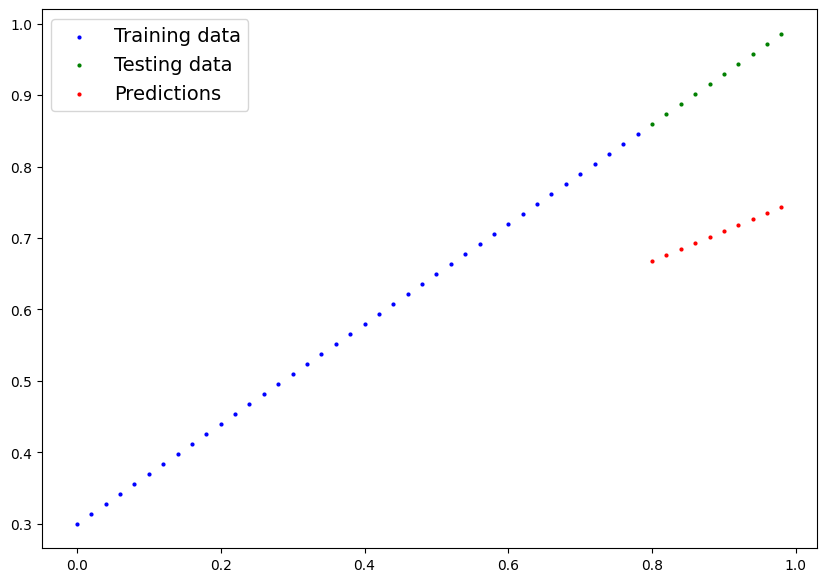

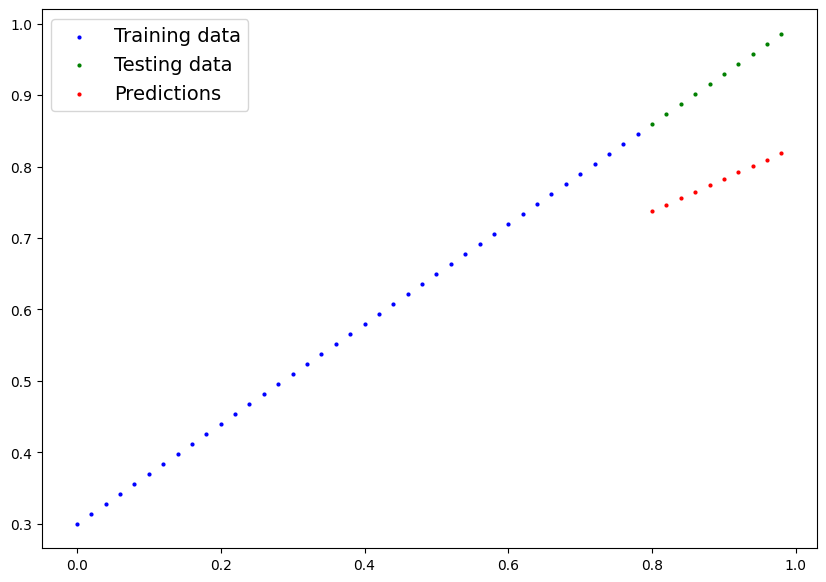

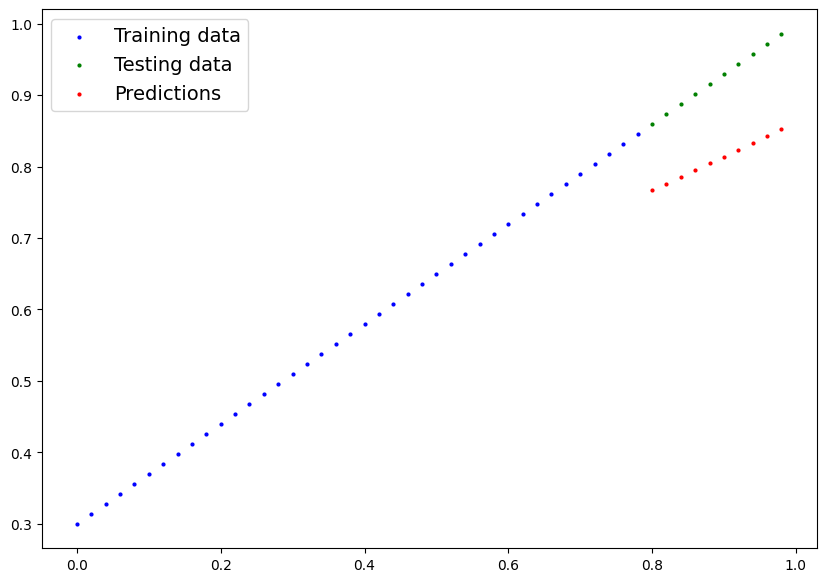

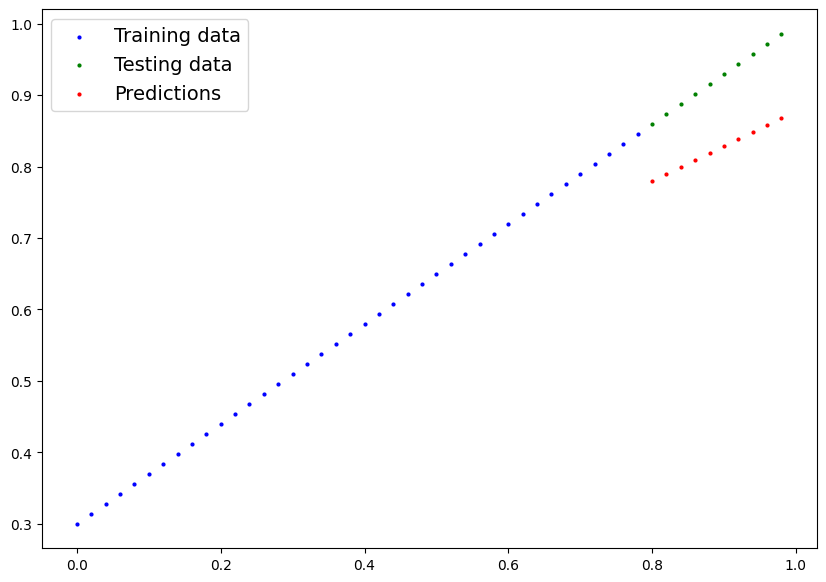

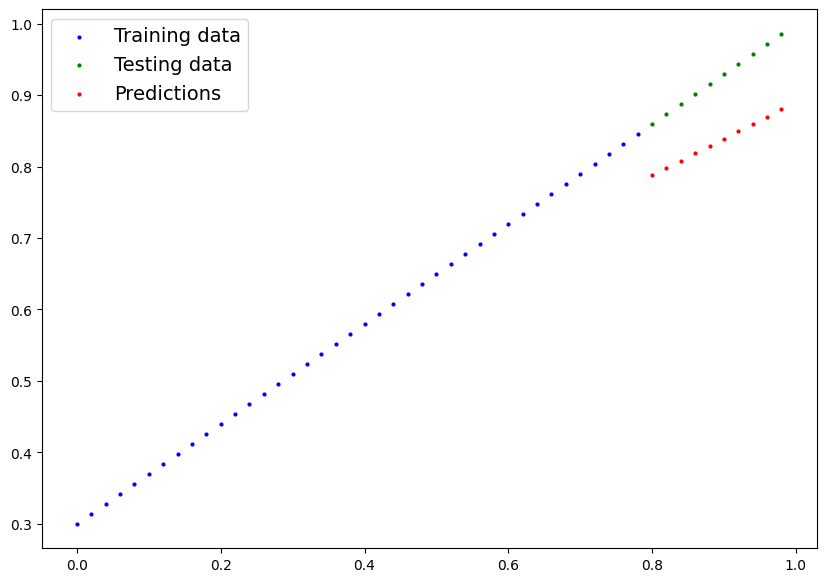

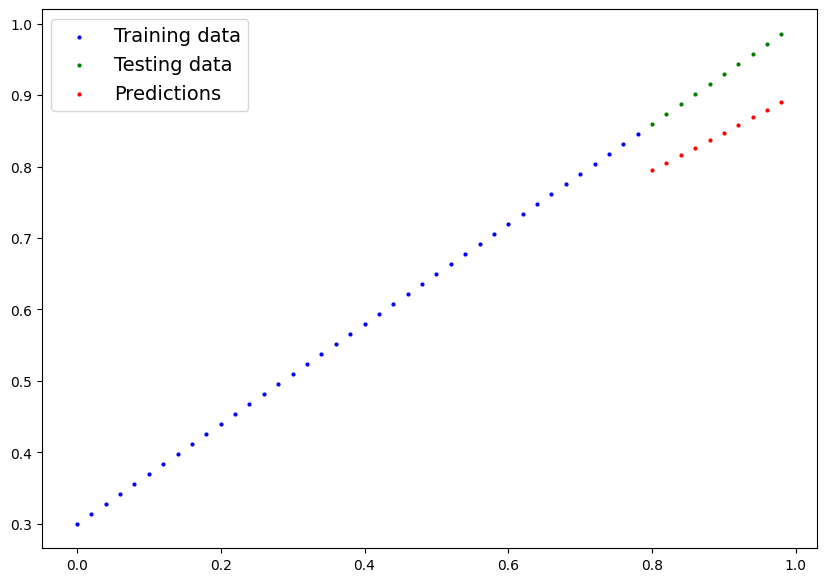

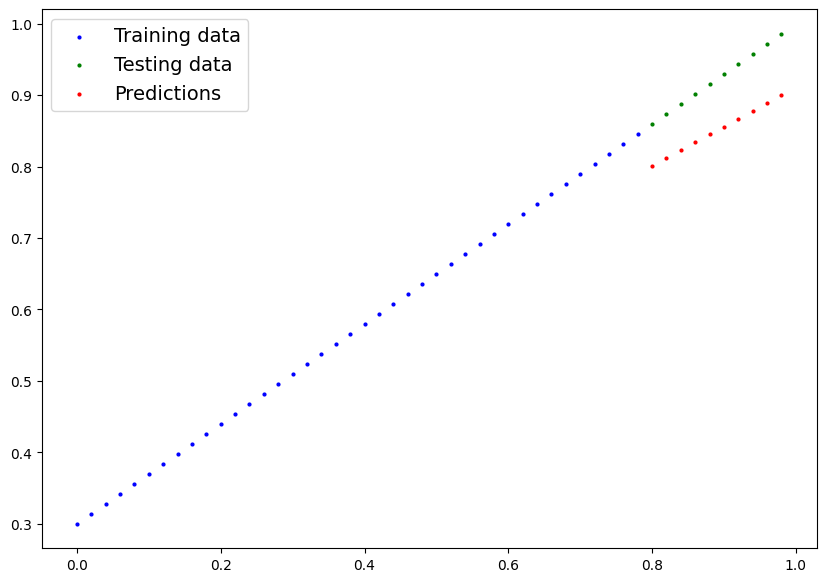

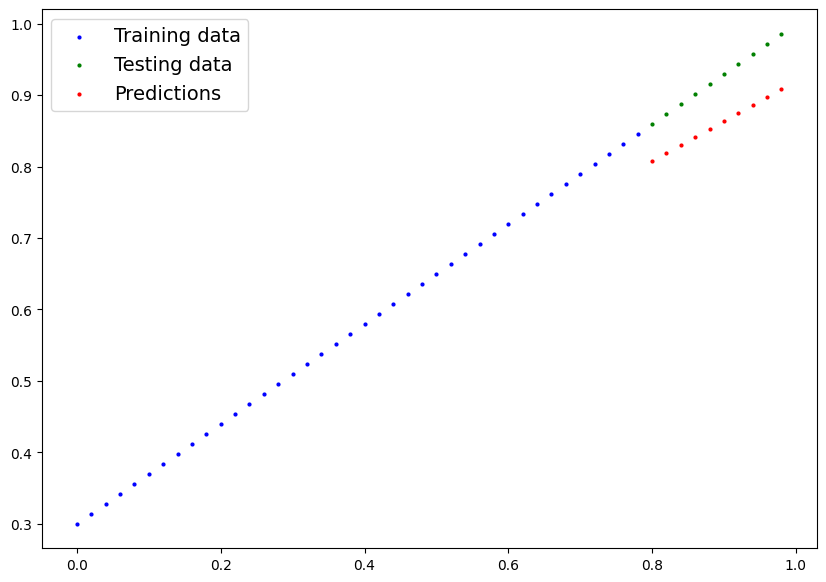

In [32]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
            plot_predictions(predictions=test_pred)

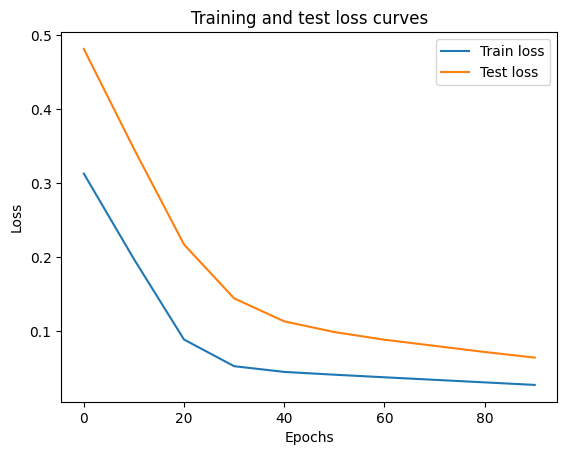

In [33]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### Дополнительные материалы

1. Отличный [сайт](https://fmin.xyz/docs/methods/fom/SGD.html) с материалами по математике для обучения нейронных сетей
2. Лекции по [оптимизации](https://youtube.com/playlist?list=PLQSHEO58cjmMzyrmw1yzbGw7_ScEJL7Na&si=MKeLpQuQ-UDI33Qs)